In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pickle

In [178]:
# Put csv into df
df = pd.read_csv('data.csv')

In [179]:
MU_MAX = 10e10
MU_MIN = 10e-10

class SimplifiedWickelgren:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_ = delta / (24 * 60 * 60)
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return -1. * np.divide(np.log(1 + delta_), (np.log(retention_rate_clipped)))

    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_ = delta / (24 * 60 * 60)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1.,mu)
        return np.power(1. + delta_, exponent)

    @staticmethod
    def get_name():
        return "SWP"

    
class MTR:
    def __init__(self):
        self.model = LinearRegression
        self.column_names = []
    
    def load(self):
        with open('model.pkl', 'rb') as file:
            self.model = pickle.load(file)
        
        with open('column_names.pkl', 'rb') as file:
            self.column_names = pickle.load(file)
    
    def predict_to_df(self, df):
        X = df[self.column_names]
        delta = df['delta']
        mu_pred = self.model.predict(X)
        df['score_pred'] = SimplifiedWickelgren.calculate_retention_rate(mu_pred, delta)
        return df
        
        

In [180]:
NEVER = 62208000
def engineer_features(X):
    for feature_name in X.columns:
        if 'seconds' in feature_name:
            mask = X[feature_name].where(X[feature_name]<NEVER)
            inverse = np.clip(np.divide(1.0, mask), 10e-10, 10e-6)
            log_inverse = np.log(inverse)
            X[feature_name+"_inverse"] = np.nan_to_num(inverse)
            X[feature_name+"_log_inverse"] = np.nan_to_num(log_inverse)
            if 'FIRST_EXPOSURE' in feature_name:
                continue
            X.drop(feature_name, axis=1, inplace=True)
        if 'amount' in feature_name:
            X[feature_name+"_sqrt"] = np.sqrt(X[feature_name])
    return X

In [198]:
# Separate features and label
X = df.drop(['score', 'delta', 'score_prev'], axis=1)

# Save column names
X.sort_index(axis=1, inplace=True)
columns = X.columns
X = engineer_features(X)
X[X.columns] = MinMaxScaler().fit_transform(X)

score = df['score']
score_prev = df['score_prev']
delta = df['delta']
weights = np.power(np.clip(score_prev- score, 0, 1)*delta, 2)
weights = None
# Calculate mu
mu = SimplifiedWickelgren.calculate_mu(score, delta)

# Fit for mu
model = LinearRegression()
model.fit(X, mu, sample_weight=weights)
mu_pred = model.predict(X)
score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)
# Save weights and intercepts

<AxesSubplot:>

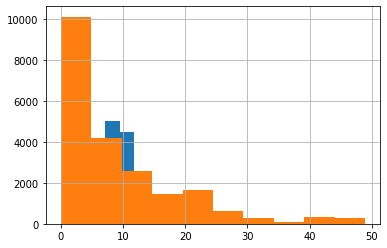

In [193]:
pd.Series(np.clip(mu_pred, MU_MIN, MU_MAX)).hist()
mu.hist()

<AxesSubplot:>

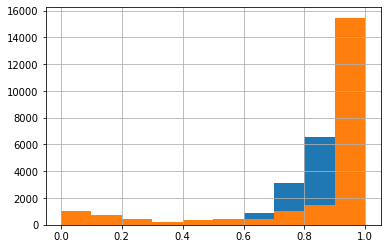

In [194]:
score_pred.hist()
score.hist()

score         8.435235e-01
score_pred    8.551866e-01
mae           1.881602e-01
mse           8.145705e-02
optimism      1.166316e-02
wmse          8.375482e+10
dtype: float64

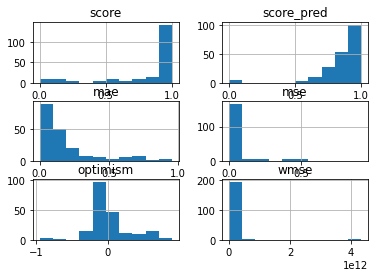

In [202]:
pd.set_option('max_rows', 200)
wmse = np.power(np.multiply(score_prev- score,delta), 2)
summary = pd.DataFrame({
    'score': score,
    'score_pred': score_pred,
    'mae': np.abs(score-score_pred),
    'mse': np.multiply((score-score_pred), (score-score_pred)),
    'optimism': score_pred-score,
    'wmse': wmse
}).sample(200)
summary.hist()
summary.mean()

In [203]:
for name, coef in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(name, coef)

ALL_amount_sqrt 1083633.7805726212
TEXT__SENTENCE_CLICK_amount -719015.5642766277
VIDEO__WAS_SEEN_amount -443790.33929741563
VIDEO__TRANSLATION_WAS_REVEALED_amount -392626.12271876977
TEXT__SENTENCE_READ_amount -363832.9393320403
REVISION__CLICKED_amount -2004.0812982691898
BOOK_DRILL_SCROLL_amount -1999.063041589221
REVISION__NOT_CLICKED_amount -1777.1297875643634
BOOK_DRILL_CLICK_amount -1253.6887368844289
TEXT__WORD_HIGHLIGHTED_amount -937.2073731711475
ALL_leading_recalls_amount -311.7478084292073
TEXT__SENTENCE_READ_amount_sqrt -32.82345692277311
TEXT__SENTENCE_CLICK_amount_sqrt -30.96497858982171
FIRST_EXPOSURE_seconds_log_inverse -23.12506404567614
FIRST_EXPOSURE_seconds -23.06044816528294
ALL_leading_recalls_amount_sqrt 21.88674483495634
FIRST_EXPOSURE_seconds_inverse 11.420474568818252
BOOK_DRILL_CLICK_amount_sqrt -10.77068482956941
VIDEO__WAS_SEEN_amount_sqrt -9.78029257059135
VIDEO__TRANSLATION_WAS_REVEALED_amount_sqrt 7.196532030429576
TEXT__WORD_HIGHLIGHTED_amount_sqrt -7.

In [204]:
# Save columns
with open('column_names.pkl', 'wb') as file:
    pickle.dump(columns, file)

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


<AxesSubplot:>

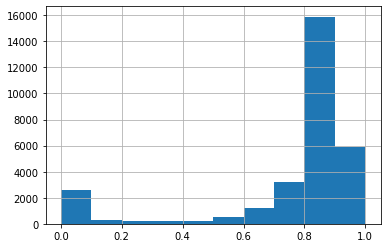

In [69]:
mtr = MTR()
mtr.load()
mtr.predict_to_df(df)['score_pred'].hist()

<AxesSubplot:>

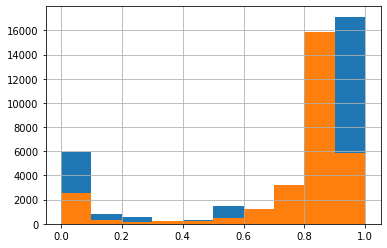

In [66]:
pd.DataFrame({'mu': mu, 'mu_pred': mu_pred, 'score': score, 'score_pred': score_pred})
score.hist()
score_pred.hist()

In [13]:
X

,ALL_amount,ALL_leading_failures_amount,ALL_leading_failures_seconds,ALL_leading_recalls_amount,ALL_leading_recalls_seconds,ALL_longest_leading_recalls_seconds,BOOK_DRILL_CLICK_amount,BOOK_DRILL_CLICK_seconds,BOOK_DRILL_SCROLL_amount,BOOK_DRILL_SCROLL_seconds,...,TEXT__SENTENCE_CLICK_amount,TEXT__SENTENCE_CLICK_seconds,TEXT__SENTENCE_READ_amount,TEXT__SENTENCE_READ_seconds,TEXT__WORD_HIGHLIGHTED_amount,TEXT__WORD_HIGHLIGHTED_seconds,VIDEO__TRANSLATION_WAS_REVEALED_amount,VIDEO__TRANSLATION_WAS_REVEALED_seconds,VIDEO__WAS_SEEN_amount,VIDEO__WAS_SEEN_seconds
0,3,0,0,0,0,0,0,62208000,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
1,3,0,0,1,491,491,0,62208000,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
2,6,0,0,2,545,545,0,62208000,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
3,6,0,0,2,605,605,0,62208000,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
4,6,0,0,2,606,606,0,62208000,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,10,1,82002,0,0,0,2,82002,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
20058,15,2,1054583,0,0,0,2,1054583,0,62208000,...,0,62208000,0,62208000,0,62208000,0,62208000,0,62208000
20059,528,5,857174,2,661,661,1,857174,0,62208000,...,15,1496529,0,62208000,1,11708616,6,3961608,0,62208000
20060,55,1,576112,1,826250,826250,2,0,0,62208000,...,4,1058561,2,1102136,1,2011938,1,3998077,0,62208000


In [12]:
df.columns

Index(['TEXT__WORD_HIGHLIGHTED_seconds', 'TEXT__WORD_HIGHLIGHTED_amount',
       'TEXT__SENTENCE_CLICK_seconds', 'TEXT__SENTENCE_CLICK_amount',
       'TEXT__SENTENCE_READ_seconds', 'TEXT__SENTENCE_READ_amount',
       'REVISION__CLICKED_seconds', 'REVISION__CLICKED_amount',
       'REVISION__NOT_CLICKED_seconds', 'REVISION__NOT_CLICKED_amount',
       'VIDEO__WAS_SEEN_seconds', 'VIDEO__WAS_SEEN_amount',
       'VIDEO__TRANSLATION_WAS_REVEALED_seconds',
       'VIDEO__TRANSLATION_WAS_REVEALED_amount', 'BOOK_DRILL_CLICK_seconds',
       'BOOK_DRILL_CLICK_amount', 'BOOK_DRILL_SCROLL_seconds',
       'BOOK_DRILL_SCROLL_amount', 'FIRST_EXPOSURE_seconds', 'delta',
       'ALL_longest_leading_recalls_seconds', 'ALL_leading_recalls_amount',
       'ALL_leading_recalls_seconds', 'ALL_leading_failures_amount',
       'ALL_leading_failures_seconds', 'ALL_amount', 'score', 'score_prev'],
      dtype='object')

In [56]:
X_engineered = engineer_features(X)

seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds


In [57]:
X_engineered

,ALL_amount,ALL_leading_failures_amount,ALL_leading_recalls_amount,BOOK_DRILL_CLICK_amount,BOOK_DRILL_SCROLL_amount,FIRST_EXPOSURE_seconds,REVISION__CLICKED_amount,REVISION__NOT_CLICKED_amount,TEXT__SENTENCE_CLICK_amount,TEXT__SENTENCE_READ_amount,...,TEXT__WORD_HIGHLIGHTED_seconds_inverse,TEXT__WORD_HIGHLIGHTED_seconds_log_inverse,VIDEO__TRANSLATION_WAS_REVEALED_seconds_inverse,VIDEO__TRANSLATION_WAS_REVEALED_seconds_log_inverse,VIDEO__WAS_SEEN_seconds_inverse,VIDEO__WAS_SEEN_seconds_log_inverse,ALL_leading_failures_seconds_inverse_inverse,ALL_leading_failures_seconds_inverse_log_inverse,ALL_leading_failures_seconds_log_inverse_inverse,ALL_leading_failures_seconds_log_inverse_log_inverse
0,3,0,0,0,0,487,1,1,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
1,3,0,1,0,0,491,0,2,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
2,6,0,2,0,0,545,0,3,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
3,6,0,2,0,0,605,0,3,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
4,6,0,2,0,0,606,0,3,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,10,1,0,2,0,529132,1,1,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
20058,15,2,0,2,0,1501713,2,1,0,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
20059,528,5,2,1,0,12400742,6,3,15,0,...,8.540719e-08,-16.275836,2.524228e-07,-15.192161,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266
20060,55,1,1,2,0,3998077,0,0,4,2,...,4.970332e-07,-14.514609,2.501202e-07,-15.201324,0.0,0.0,0.00001,-11.512925,1.000000e-09,-20.723266


In [51]:
for feature_name in X.columns:
    if 'seconds' in feature_name:
        print('seconds')

seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
seconds
